**$$\textbf{Interpolación Cúbica con Estimación de Parámetros}$$**
$\textbf{}$
$$\textbf{José Muñoz Casares}$$

In [1]:
# Carga de Librerias
import pandas as pd
import numpy as np
from scipy.linalg import solve
import seaborn as sns
import warnings
import altair as alt
import ipywidgets as widgets
from pprint import pprint
import matplotlib.pyplot as plt

# Ignorar advertencias
warnings.filterwarnings('ignore')

In [2]:
# Cargar los datos
tasa = pd.read_csv("TIIE.csv")

# Extraer datos del DataFrame
X = tasa['Plazo'].dropna().values
Y = tasa['Tasa Cupon Cero'].dropna().values

In [3]:
def cubic_interpolation_with_slope_estimation(X, Y):
  n = len(X)  # Número de nodos

  # Construir la matriz de coeficientes A y el vector de términos independientes b
  A = np.zeros((4 * n - 4, 4 * n - 4))
  b = np.zeros(4 * n - 4)

  # Primera propiedad: Congruencia con los nodos originales
  for i in range(n - 1):
      A[i, 4 * i + 3] = 1
      b[i] = Y[i]

  # Segunda propiedad: Continuidad (with corrected upper bound for slicing)
  for i in range(n - 2):
      A[n - 1 + i, 4 * i : 4 * i + 4] = [
          (X[i + 1] - X[i]) ** 3,
          (X[i + 1] - X[i]) ** 2,
          X[i + 1] - X[i],
          1,
      ]
      A[n - 1 + i, 4 * i + 4 : 4 * i + 7] = [0, 0, 0]
      b[n - 1 + i] = Y[i + 1]

  A[2 * n - 3, 4 * n - 8 : 4 * n - 4] = [
      (X[n - 1] - X[n - 2]) ** 3,
      (X[n - 1] - X[n - 2]) ** 2,
      X[n - 1] - X[n - 2],
      1,
  ]
  b[2 * n - 3] = Y[n - 1]

  # Tercera propiedad: Derivabilidad (suavidad)
  for i in range(1, n - 1):
      A[2 * n - 2 + i - 1, 4 * i - 4 : 4 * i] = [ # Adjusted index for A
          3 * (X[i] - X[i - 1]) ** 2,
          2 * (X[i] - X[i - 1]),
          1,
          0,
      ]
      A[2 * n - 2 + i - 1, 4 * i : 4 * i + 4] = [0, 0, -1, 0] # Adjusted index for A

  # Cuarta propiedad: Condiciones de frontera
  A[3 * n - 4, 0:4] = [0, 0, 1, 0]
  m1 = (Y[1] - Y[0]) / (X[1] - X[0])
  b[3 * n - 4] = m1

  A[3 * n - 3, 4 * n - 8 : 4 * n - 4] = [
      3 * (X[n - 1] - X[n - 2]) ** 2,
      2 * (X[n - 1] - X[n - 2]),
      1,
      0,
  ]
  mn = (Y[n - 1] - Y[n - 2]) / (X[n - 1] - X[n - 2])
  b[3 * n - 3] = mn

  # Quinta propiedad: Estimación lineal de pendientes (with adjusted upper bound)
  for i in range(1, n - 1):
      m_prev = (Y[i] - Y[i - 1]) / (X[i] - X[i - 1])
      m_next = (Y[i + 1] - Y[i]) / (X[i + 1] - X[i])

      if m_prev * m_next <= 0:
          mi = 0
      else:
          mi = m_prev/3 + (2*m_next)/3

      A[3 * n - 2 + i - 1, 4 * i - 4 : 4 * i] = [ # Adjusted index for A
          3 * (X[i] - X[i - 1]) ** 2,
          2 * (X[i] - X[i - 1]),
          1,
          0,
      ]
      b[3 * n - 2 + i - 1] = mi  # Adjusted index for b

  # Resolver el sistema de ecuaciones para obtener los coeficientes
  coefficients = solve(A, b)

  # Comprobar si se ha encontrado una solución única
  if coefficients is None:
      print("I'm sorry Dave, I'm afraid I can't do that, Error: No se pudo encontrar una solución única para los coeficientes.")
      return None
  return coefficients

# Aplicar la interpolación
coefficients = cubic_interpolation_with_slope_estimation(X, Y)

# Comprobar si se han encontrado los coeficientes
if coefficients is None:
    print("I'm sorry Dave, I'm afraid I can't do that, Error: No se puede continuar con la visualización debido a la falta de coeficientes.")
else:
    # Imprimir los coeficientes
    for i in range(len(X) - 1):
        a, b, c, d = coefficients[4 * i : 4 * i + 4]
        print(f"Polinomio {i + 1}:")
        print(f"  a_{i + 1} = {a:.6f}, b_{i + 1} = {b:.6f}, c_{i + 1} = {c:.6f}, d_{i + 1} = {d:.6f}")

    # Generar puntos (nodos) para la interpolación
    x_interp = np.linspace(X.min(), X.max(), 1)
    y_interp = []

    # Calcular valores interpolados
    for x in x_interp:
        for i in range(len(X) - 1):
            if X[i] <= x <= X[i + 1]:
                a, b, c, d = coefficients[4 * i : 4 * i + 4]
                y = a * (x - X[i]) ** 3 + b * (x - X[i]) ** 2 + c * (x - X[i]) + d
                y_interp.append(y)
                break


Polinomio 1:
  a_1 = -0.000001, b_1 = 0.000039, c_1 = 0.001145, d_1 = 7.911800
Polinomio 2:
  a_2 = 0.000001, b_2 = -0.000031, c_2 = 0.000000, d_2 = 7.945000
Polinomio 3:
  a_3 = -0.000008, b_3 = 0.000514, c_3 = 0.000000, d_3 = 7.935000
Polinomio 4:
  a_4 = -0.000002, b_4 = 0.000066, c_4 = 0.008581, d_4 = 8.175000
Polinomio 5:
  a_5 = -0.000003, b_5 = 0.000074, c_5 = 0.007401, d_5 = 8.450000
Polinomio 6:
  a_6 = 0.000000, b_6 = -0.000055, c_6 = 0.002975, d_6 = 8.650000
Polinomio 7:
  a_7 = -0.000001, b_7 = 0.000012, c_7 = 0.000821, d_7 = 8.720000
Polinomio 8:
  a_8 = 0.000029, b_8 = -0.001518, c_8 = -0.000000, d_8 = 8.740000
Polinomio 9:
  a_9 = -0.000019, b_9 = 0.000691, c_9 = -0.011304, d_9 = 8.136800
Polinomio 10:
  a_10 = 0.000001, b_10 = -0.000171, c_10 = -0.019815, d_10 = 7.920000
Polinomio 11:
  a_11 = 0.000016, b_11 = -0.000481, c_11 = -0.028091, d_11 = 6.301200
Polinomio 12:
  a_12 = -0.000001, b_12 = 0.000210, c_12 = -0.017584, d_12 = 5.486900
Polinomio 13:
  a_13 = 0.000000,

Datos Originales


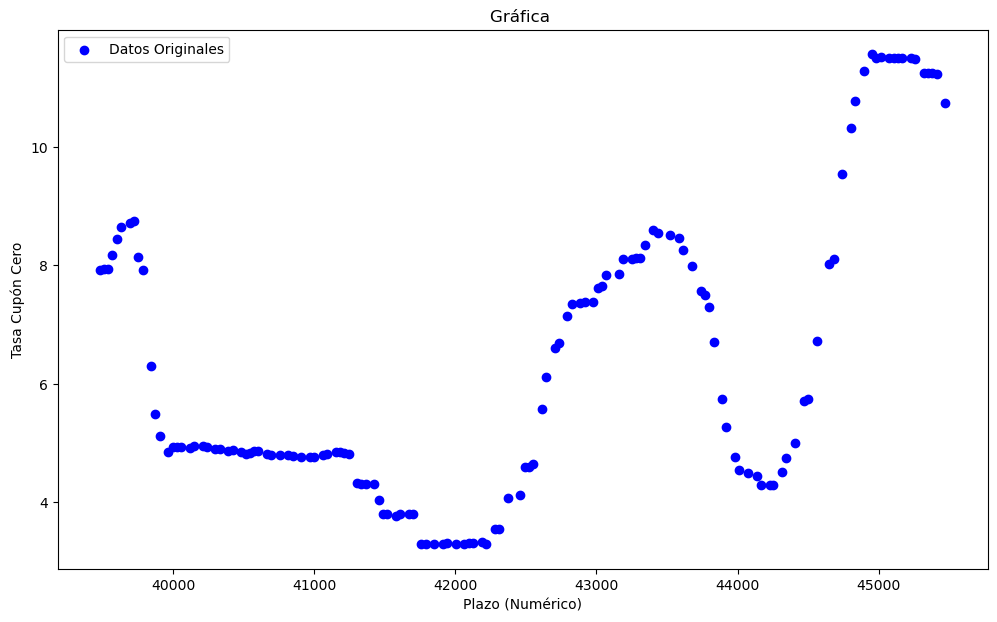

In [4]:
print("Datos Originales")

plt.figure(figsize=(12, 7))
plt.scatter(X, Y, color='blue', label='Datos Originales')
plt.title('Gráfica ')
plt.xlabel('Plazo (Numérico)')
plt.ylabel('Tasa Cupón Cero')
plt.legend() 
plt.show()


Nota: Los valores del siguiente código se irán cambiando dependiendo de lo que se quiera calulcula

In [5]:
# Aplicar la interpolación

coefficients = cubic_interpolation_with_slope_estimation(X, Y)

if coefficients is None:
    print("I'm sorry Dave, I'm afraid I can't do that, Error: No se puede continuar con la visualización debido a la falta de coeficientes.")
else:
    x_input = widgets.FloatText(
        value=X.min(),
        description='Valor de X:',
        disabled=False
    )
    output = widgets.Output()

    # Función para gestionar el cambio de entrada y mostrar los resultados
    def on_value_change(change):
        with output:
            output.clear_output(wait=True)

            x_estimado = change['new']
            found = False

            # Buscamos el polinomio correspondiente al valor de X
            for i in range(len(X) - 1):
                if X[i] <= x_estimado <= X[i + 1]:
                    found = True
                    a, b, c, d = coefficients[4*i : 4*i+4] # Extracción de los coeficientes del polinomio que se usará

                    # valor de Y estimado
                    y_estimado = a*(x_estimado - X[i])**3 + b*(x_estimado - X[i])**2 + c*(x_estimado - X[i]) + d

                    print(f"Como X ∈ [{X[i]}, {X[i + 1]}], entonces la ecuación del polinomio es:")
                    print(f"S_{i + 1}(X) = {a:.6f}(X - {X[i]:.2f})^3 + {b:.6f}(X - {X[i]:.2f})^2 + {c:.6f}(X - {X[i]:.2f}) + {d:.6f}")

                    # gráfico
                    plt.figure(figsize=(12, 7))

                    plt.scatter(X, Y, color='blue', label='Original Data')

                    plt.scatter(x_estimado, y_estimado, color='red', s=100, zorder=5, label=f'Punto estimado ({x_estimado:.2f}, {y_estimado:.2f})')

                    plt.title('Gráfica')
                    plt.xlabel('Plazo')
                    plt.ylabel('Tasa Cupón Cero')
                    plt.legend()
                    plt.grid(True)
                    plt.show()
                    break

            if not found:
                # Si el valor está fuera de rango
                print(f"El valor X = {x_estimado:.2f} está fuera del rango de los datos originales.")
                plt.figure(figsize=(12, 7))
                plt.scatter(X, Y, color='blue', label='Original Data')
                plt.title('Datos Originales de la Curva Gubernamental')
                plt.xlabel('Plazo')
                plt.ylabel('Tasa Cupón Cero')
                plt.legend()
                plt.grid(True)
                plt.show()

    x_input.observe(on_value_change, names='value')
    display(x_input, output)

    # Forzamos la ejecución inicial para que muestre el primer punto
    on_value_change({'new': x_input.value})

FloatText(value=39478.0, description='Valor de X:')

Output()